In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer

import sys
import pathlib
from os.path import join
path_to_file = str(pathlib.Path().resolve())
dir_path = join(path_to_file, "../../")
sys.path.append(join(dir_path, "HelperFiles"))
from helper import *
from load_data import *
from train_models import *
from top_k import *
from retrospective import *
# from sprtshap import *
import warnings
warnings.filterwarnings('ignore')
import shap
data_path = join(dir_path, "Experiments", "Data")

In [5]:
X_train, y_train, X_test, y_test, mapping_dict = load_data(data_path, "breast_cancer")
d = X_train.shape[1]
print(len(y_test), np.mean(y_test))
model = train_rf(X_train, y_train)
# model = train_neural_net(X_train, y_train)

y_preds = (model(X_test) > 0.5).astype("int")
print("{}% accuracy".format(round(np.mean(y_preds == y_test)*100)))

171 0.631578947368421
94% accuracy


## Run many times
### SHAP

In [6]:
np.random.seed(1)
x_idx = 1
# xloc = X_test[x_idx]
xloc = X_test[x_idx]
N_runs = 25
n_per_feat = 250
shap_vals_all = []
kmeans = shap.kmeans(X_train, 10)
explainer = shap.SamplingExplainer(model, kmeans)
for i in range(N_runs):
    # shap_vals = shapley_sampling(model, X_train, xloc, n_perms=250, 
    #                     n_samples_per_perm=1, mapping_dict=mapping_dict)
    shap_vals = explainer.shap_values(xloc, nsamples=n_per_feat*d, silent=True)[0]
    shap_vals_all.append(shap_vals)
    if (i+1)%5==0:print(i+1)


5
10
15
20
25


In [4]:
np.random.seed(1)
kshap_vals_all = []
explainer = shap.KernelExplainer(model, kmeans)
for i in range(N_runs):
    kshap_values = explainer.shap_values(xloc, nsamples=n_per_feat*d, silent=True)[0]
    # kshap_values = kernelshap(model, X_train, xloc, n_perms=250*d, n_samples_per_perm=1, mapping_dict=mapping_dict)
    kshap_vals_all.append(kshap_values)
    if (i+1)%5==0:print(i+1)


5
10
15
20
25


In [18]:
order_ss = [get_ranking(shap_values, abs=False) for shap_values in shap_vals_all]
order_kshap = [get_ranking(kshap_values, abs=False) for kshap_values in kshap_vals_all]

K = 5
# cols_ss = []
freqs_ss = []
top_K_ss = np.array(order_ss)[:,:K]
for k in range(K):
    most_common = np.argmax(np.bincount(top_K_ss[:,k]))
    # cols_ss.append(colnames[most_common])
    print(most_common) # Verify they're unique
    freqs_ss.append(np.mean(top_K_ss[:,k]==most_common))
print(freqs_ss)

# cols_kshap = []
freqs_kshap = []
top_K_kshap = np.array(order_kshap)[:,:K]
for k in range(K):
    most_common = np.argmax(np.bincount(top_K_kshap[:,k]))
    print(most_common) # Verify they're unique
    freqs_kshap.append(np.mean(top_K_kshap[:,k]==most_common))
print(freqs_kshap)

print(calc_fwer(top_K_ss))
print(calc_fwer(top_K_kshap))


22
17
1
14
16
[np.float64(1.0), np.float64(0.92), np.float64(0.44), np.float64(0.48), np.float64(0.4)]
22
13
2
1
0
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.88), np.float64(0.8)]
0.0
0.0


In [32]:
# import importlib
# import helper
# # helper.calc_fwer(top_K_ss)
# top_K = top_K_ss
# most_common_row = helper.mode_rows(top_K)
# relevant_top_K = np.array(top_K)
# num_false_rejections = np.sum(np.all(relevant_top_K!=most_common_row,axis=1)).item()
# num_total_trials = len(top_K)
# fwer = num_false_rejections/num_total_trials
# num_false_rejections

0

In [44]:
# np.all(relevant_top_K!=most_common_row,axis=1)
# most_common_row
# relevant_top_K
# np.sum([1-np.array_equal(top_K_row, most_common_row) for top_K_row in relevant_top_K]).item()

20

In [ ]:
# np.random.seed(1)
xloc = X_test[x_idx]
rankshap_vals_all = []
ct = 0
while len(rankshap_vals_all) < N_runs:
    rankshap_vals, _, _, converged = rankshap(model, X_train, xloc, K=5, alpha=0.2, abs=False, n_samples_per_perm=30, max_n_perms=n_per_feat)
    rankshap_vals_all.append(rankshap_vals)
    ct += 1
    if ct%5==0:print(ct)


5
10
15
20
25


In [7]:
order_rs = [get_ranking(shap_values, abs=False) for shap_values in rankshap_vals_all]

K = 5
# cols_rs = []
freqs_rs = []
top_K_rs = np.array(order_rs)[:,:K]
for k in range(K):
    most_common = np.argmax(np.bincount(top_K_rs[:,k]))
    # cols_rs.append(colnames[most_common])
    print(most_common) # Verify they're unique
    freqs_rs.append(np.mean(top_K_rs[:,k]==most_common))
print(freqs_rs)

22
13
2
17
0
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.76)]


## LIME

In [8]:
x_idx = 1
K = 5
xloc = X_test[x_idx]
top_K_lime = []
from slime import lime_tabular
model = train_model(X_train, y_train, "rf", lime=True)
explainer = lime_tabular.LimeTabularExplainer(X_train, 
                                              discretize_continuous = False, 
                                              feature_selection = "lasso_path", 
                                              sample_around_instance = True)
for _ in range(N_runs):
    exp = explainer.explain_instance(xloc, model, num_features = K, num_samples = 1000) # Default
    tuples = exp.local_exp[1]
    feats = [tuples[i][0] for i in range(5)]
    top_K_lime.append(feats)
print(calc_fwer(top_K_lime))


0.0


### SLIME

In [10]:
top_K_slime = []
while len(top_K_slime) < N_runs:
    exp, converged = explainer.slime(xloc, model, num_features = K, 
                                num_samples = 1000, n_max = 50000, #100000
                                alpha = 0.2/K/2, tol=1e-4, return_none=True)
    if converged:
        tuples = exp.local_exp[1]
        feats = [tuples[i][0] for i in range(K)]
        top_K_slime.append(feats)
print(calc_fwer(top_K_slime))

0.0


In [11]:
# fname = "lime_vs_slime"
# with open(join(dir_path, "Experiments", "Results", "alpha0.2", fname), "rb") as fp:
#         top_Ks = pickle.load(fp)
# top_K_lime, top_K_slime = np.array(top_Ks[0]), np.array(top_Ks[1])
top_K_lime, top_K_slime = np.array(top_K_lime), np.array(top_K_slime)

###### Get frequencies of top-5 lime and S-LIME features
cols_lime = []
freqs_lime = []
K = 5
breast_cancer = load_breast_cancer()
colnames = breast_cancer.feature_names
for k in range(K):
    most_common = np.argmax(np.bincount(top_K_lime[:,k]))
    cols_lime.append(colnames[most_common])
    print(most_common) # Verify they're unique
    freqs_lime.append(np.mean(top_K_lime[:,k]==most_common))
print(freqs_lime)

cols_slime = []
freqs_slime = []
for k in range(K):
    most_common = np.argmax(np.bincount(top_K_slime[:,k]))
    cols_slime.append(colnames[most_common])
    print(most_common) # Verify they're unique
    freqs_slime.append(np.mean(top_K_slime[:,k]==most_common))

print(freqs_slime)

22
23
20
7
27
[np.float64(1.0), np.float64(0.88), np.float64(0.48), np.float64(0.48), np.float64(0.76)]
22
23
20
7
27
[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


## Visualize

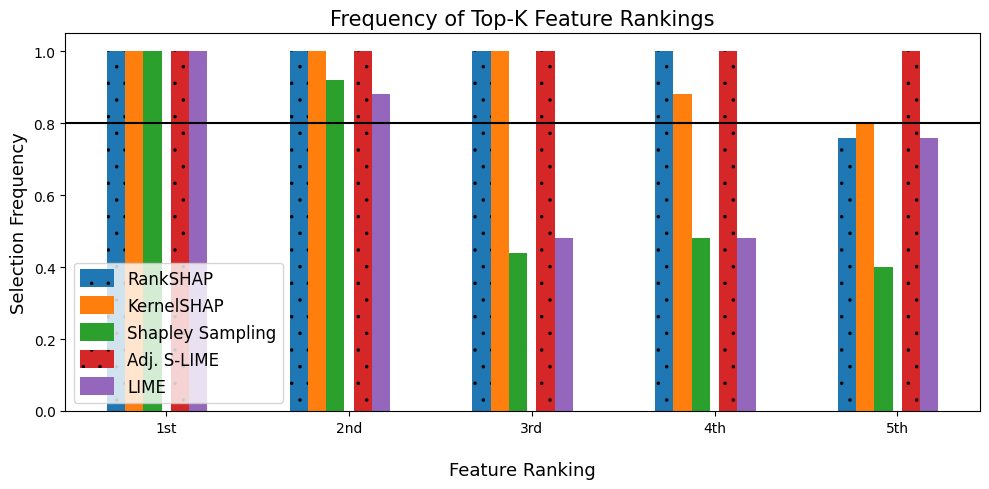

In [22]:
plt.figure(figsize=(10,5))
width = 0.1

# Plotting
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth

onetoK = np.arange(K)+1
plt.bar(onetoK-.225, freqs_rs , width, label='RankSHAP', hatch=".")
plt.bar(onetoK-.125, freqs_kshap , width, label='KernelSHAP')
plt.bar(onetoK-.025, freqs_ss, width, label='Shapley Sampling')

plt.bar(onetoK+.125, freqs_slime , width, label='Adj. S-LIME', hatch=".")
plt.bar(onetoK+.225, freqs_lime, width, label='LIME')

plt.xlabel('\nFeature Ranking', size=13)
plt.ylabel('Selection Frequency', size=13)
plt.title('Frequency of Top-K Feature Rankings', size=15)

order = ["1st", "2nd", "3rd", "4th", "5th"]
# order2 = [order[i] + '\n' + cols_slime[i].title() for i in range(K)]
plt.xticks(onetoK + width / 2, order)
plt.axhline(0.8, color="black")
# Finding the best position for legends and putting it
plt.legend(loc='lower left', prop={'size': 12}, handleheight=1.3)
plt.tight_layout()
# plt.savefig(join(dir_path, "Experiments", "Figures", "instability.png"), bbox_inches="tight")
plt.show()
